# Clipping Approaches  in  Python  with RioXarray

This notebook is a demonstration showing different outcomes from clipping methods when clipping a raster to a box with rioxarray. We noticed differences when using the inbuilt `crs=` parameter and when we transformed the `crs` ourselves. This shows those through plotting, and also shows the effects of `all_touched=True` on there. 

In [52]:
from glob import glob
import os
import warnings

import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import box, Polygon, mapping
import rasterio as rio
import earthpy as et

et.data.get_data('cs-test-naip')
et.data.get_data('cold-springs-fire')
et.data.get_data('cold-springs-modis-h4')
et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")

os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))
warnings.simplefilter('ignore')

rioxarray_option = rxr.set_options(export_grid_mapping=False)

In [53]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)

## Open and Clip Landsat Data

Below are 4  examples of  clipping Landsat data.

1. Using  `crs=` to reproject the fire boundary and  `all_touched=True`
2. Using  `crs=` to reproject the fire boundary and  `all_touched=False`
3. Remove `crs=` to reproject the fire boundary and  `all_touched=True`
2. Remove `crs=` to reproject the fire boundary and  `all_touched=False`


In [54]:
data_path = os.path.join("earthpy-downloads",
                         "landsat-coldsprings-hw")

# Open a  single f ile
all_files = sorted(glob(os.path.join(data_path,
                                     "LC080340322016062101T1-SC20200306230017",
                                     "*band[3-7]*.tif")))
band_path = all_files[0]
band_path

'earthpy-downloads/landsat-coldsprings-hw/LC080340322016062101T1-SC20200306230017/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band3.tif'

In [55]:
# reproject fire boundary to utmz

with rio.open(band_path) as src:
    landsat_crs = src.crs

crop_bound_box = [box(*fire_boundary.total_bounds)]

fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)

landsat_box = gpd.GeoDataFrame(
    geometry=[box(*fire_boundary_utmz13.total_bounds)])

# This is how rioxarray is projecting the data when you use crs=
# The reprojection is actually slightly different vs how Geopandas does it
landsat_transform = rio.warp.transform_geom(
    fire_boundary.crs, landsat_crs, crop_bound_box)
landsat_transformed_bounds = gpd.GeoDataFrame(geometry=[Polygon(
    landsat_transform[0]['coordinates'][0][::1])], crs=landsat_crs)

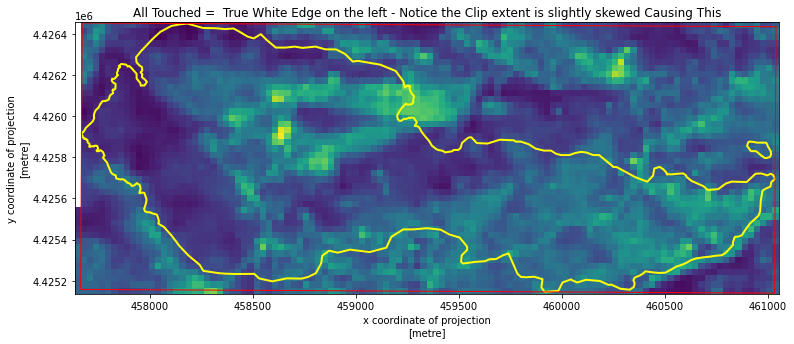

In [58]:
# Crop box here is a box not the geometry
crop_bound_box = [box(*fire_boundary.total_bounds)]

band = rxr.open_rasterio(band_path,
                         masked=True).rio.clip(crop_bound_box,
                                               crs=fire_boundary.crs,
                                               all_touched=True,
                                               from_disk=True).squeeze()

# Plot the Data
f,  ax = plt.subplots(figsize=(14, 5))
band.plot(ax=ax,
          add_colorbar=False)

fire_boundary_utmz13.plot(ax=ax,
                          edgecolor="yellow",
                          facecolor="none",
                          linewidth=2)

landsat_transformed_bounds.plot(ax=ax,
                                edgecolor="red",
                                facecolor="none",
                                linewidth=1)

ax.set(title="All Touched =  True White Edge on the left - Notice the Clip extent is slightly skewed Causing This")
plt.show()

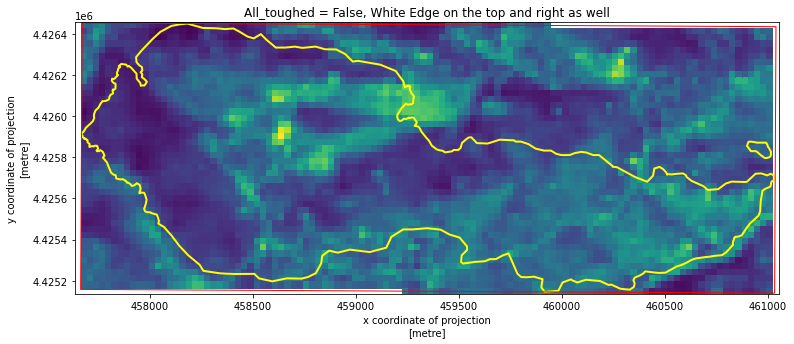

In [57]:

band = rxr.open_rasterio(band_path,
                         masked=True).rio.clip(crop_bound_box,
                                               crs=fire_boundary.crs,
                                               all_touched=False,
                                               from_disk=True).squeeze()
# Plot the Data
f,  ax = plt.subplots(figsize=(14, 5))
band.plot(ax=ax,
          add_colorbar=False)

fire_boundary_utmz13.plot(ax=ax,
                          edgecolor="yellow",
                          facecolor="none",
                          linewidth=2)

landsat_transformed_bounds.plot(ax=ax,
                                edgecolor="red",
                                facecolor="none",
                                linewidth=1)

ax.set(title="All_toughed = False, White Edge on the top and right as well")
plt.show()

It appears as if the white edges are  artifacts of how the data are reprojected 
above. It thus might be better practice to reproject first.  

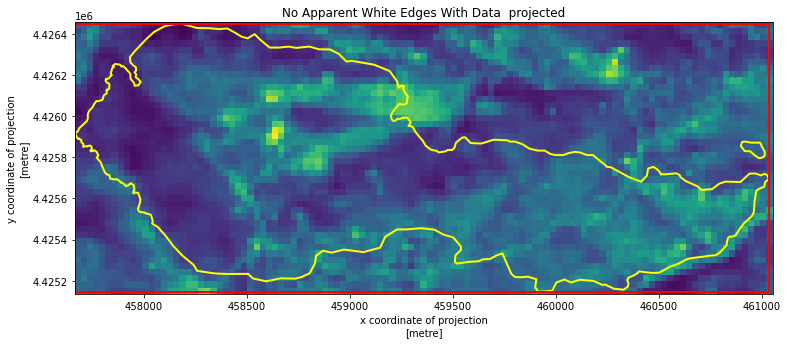

In [59]:
# Use reprojected shapefile instead

# Crop box here is a box not the geometry
crop_bound_box = [box(*fire_boundary_utmz13.total_bounds)]

# Comment out crs= you dont need it if the data are already reprojected
band_2 = rxr.open_rasterio(band_path,
                           masked=True).rio.clip(crop_bound_box,
                                                 # crs=crop_bound.crs,
                                                 all_touched=True,
                                                 from_disk=True).squeeze()

# Plot the Data
f,  ax = plt.subplots(figsize=(14, 5))
band_2.plot(ax=ax,
            add_colorbar=False)

fire_boundary_utmz13.plot(ax=ax,
                          edgecolor="yellow",
                          facecolor="none",
                          linewidth=2)

landsat_box.plot(ax=ax,
                 edgecolor="red",
                 facecolor="none",
                 linewidth=2)

ax.set(title="No Apparent White Edges With Data  projected")
plt.show()

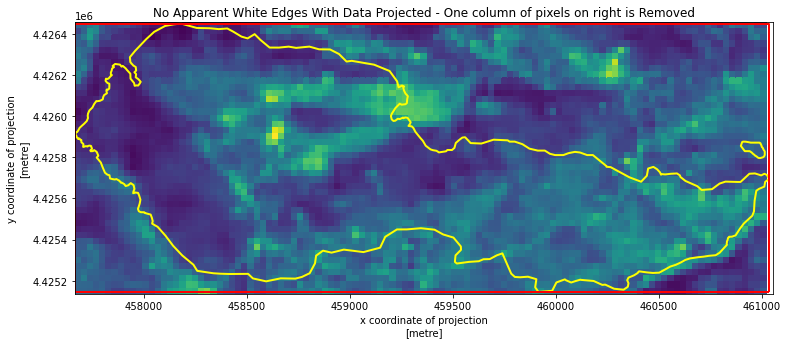

In [60]:
# Use reprojected shapefile instead

# Crop box here is a box not the geometry
crop_bound_box = [box(*fire_boundary_utmz13.total_bounds)]

# Comment out crs= you dont need it if the data are already reprojected
band_2 = rxr.open_rasterio(band_path,
                           masked=True).rio.clip(crop_bound_box,
                                                 # crs=crop_bound.crs,
                                                 all_touched=False,
                                                 from_disk=True).squeeze()

# Plot the Data
f,  ax = plt.subplots(figsize=(14, 5))
band_2.plot(ax=ax,
            add_colorbar=False)

fire_boundary_utmz13.plot(ax=ax,
                          edgecolor="yellow",
                          facecolor="none",
                          linewidth=2)

landsat_box.plot(ax=ax,
                 edgecolor="red",
                 facecolor="none",
                 linewidth=2)

ax.set(title="No Apparent White Edges With Data Projected - One column of pixels on right is Removed")
plt.show()

## Conclusions  -  Landsat  Data  Processing

It is clearly cleaner (less artifacts) to NOT use `crs=` and to 
reproject the fire boundary first. The reproject  process in rioxarray
seems to modify the data in a way that is undesirable causing edge artifacts

##  Clip Data Using Geometry vs. A Box /  Spatiat Extent
Below you can see an example of clipping the data using the geometry 
compared to a box extent.

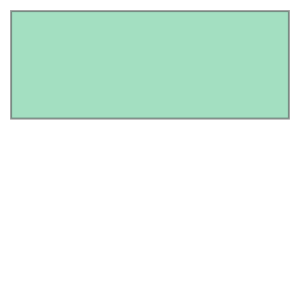

In [61]:
# Compare the shape below to this shape!
crop_bound_box[0]

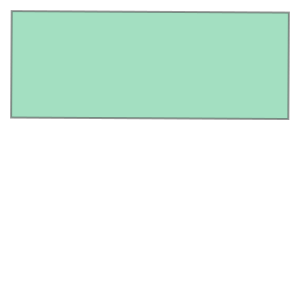

In [67]:
landsat_transformed_bounds.geometry[0]

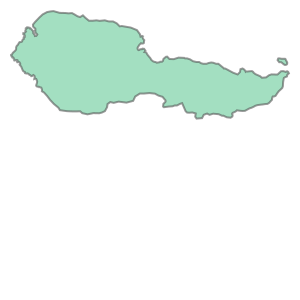

In [66]:
#  Notice the  geometry shape
fire_boundary_utmz13.geometry[0]

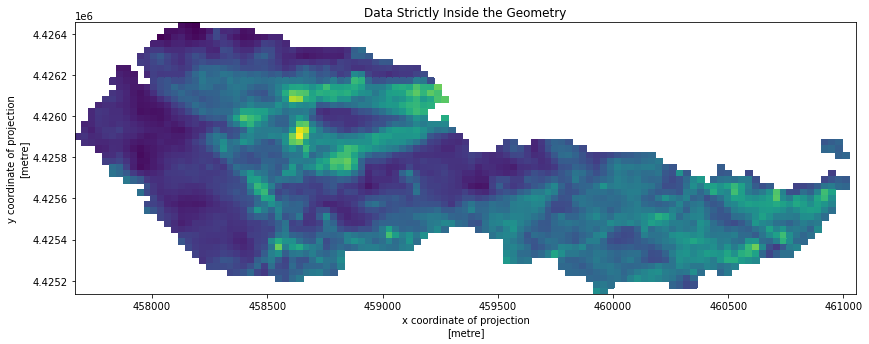

In [68]:
# Crop using the geometry rather than the bounding box
# Comment out crs= you dont need it if the data are already reprojected
band_2 = rxr.open_rasterio(band_path,
                           masked=True).rio.clip(fire_boundary_utmz13.geometry.apply(mapping),
                                                 # crs=crop_bound.crs,
                                                 all_touched=False,
                                                 from_disk=True).squeeze()

# Plot the Data
f,  ax = plt.subplots(figsize=(14, 5))
band_2.plot(ax=ax,
            add_colorbar=False)


ax.set(title="Data Strictly Inside the Geometry")
plt.show()

In [69]:
modis_h4_path = glob(os.path.join(
    "cold-springs-modis-h4", "17_july_2016", "*.hdf"))[0]

desired_bands = ["sur_refl_b01_1"]
modis_h4_path

'cold-springs-modis-h4/17_july_2016/MOD09GA.A2016199.h09v05.006.2016201065406.hdf'

In [70]:
# reproject fire boundary to sinusoidal
with rio.open(modis_h4_path) as src:
    for data in src.subdatasets:
        with rio.open(data) as data_src:
            modis_crs = data_src.crs

fire_boundary_modis = fire_boundary.to_crs(modis_crs)

fire_box = [box(*fire_boundary.total_bounds)]

modis_box = gpd.GeoDataFrame(geometry=[box(*fire_boundary_modis.total_bounds)])

# This is how rioxarray is projecting the data when you use crs=
# The reprojection is actually slightly different vs how Geopandas does it
modis_transform = rio.warp.transform_geom(fire_boundary.crs, modis_crs, fire_box)
modis_transformed_bounds = gpd.GeoDataFrame(
    geometry=[Polygon(modis_transform[0]['coordinates'][0][::1])], crs=modis_crs)

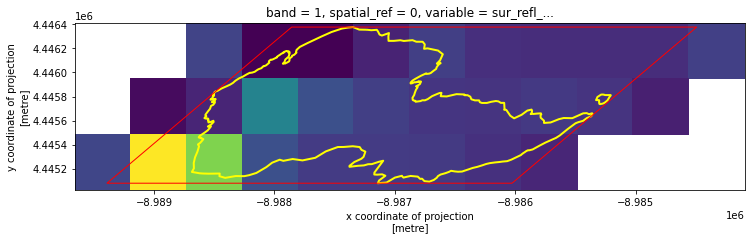

In [71]:
# Open  and
modis_crop_box = [box(*fire_boundary.total_bounds)]
modis_band = rxr.open_rasterio(modis_h4_path,
                               masked=True,
                               variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box,
                                                                     crs=fire_boundary.crs,
                                                                     all_touched=True,
                                                                     from_disk=True).squeeze()

modis_band_arr = modis_band.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_transformed_bounds.plot(ax=ax,
                              facecolor="none",
                              edgecolor="red",
                              linewidth=1)

plt.show()

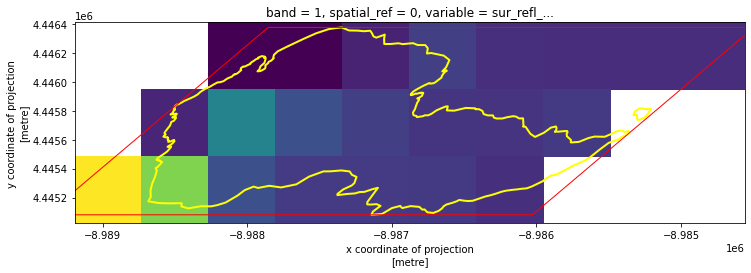

In [72]:
modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box,
                                                                       crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_transformed_bounds.plot(ax=ax,
                              facecolor="none",
                              edgecolor="red",
                              linewidth=1)

plt.show()

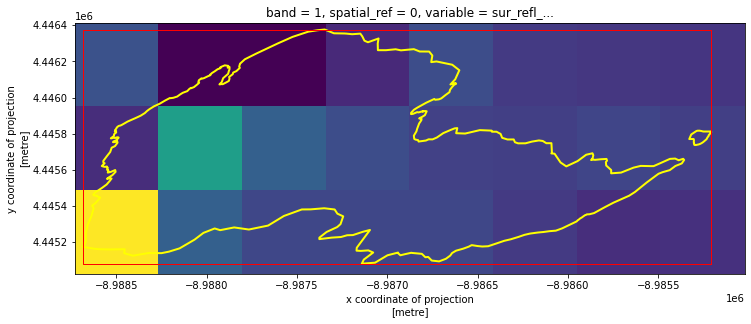

In [73]:
# reprojected box

modis_crop_box_reproj = [box(*fire_boundary_modis.total_bounds)]

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box_reproj,
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=True,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_box.plot(ax=ax,
               facecolor="none",
               edgecolor="red",
               linewidth=1)

plt.show()

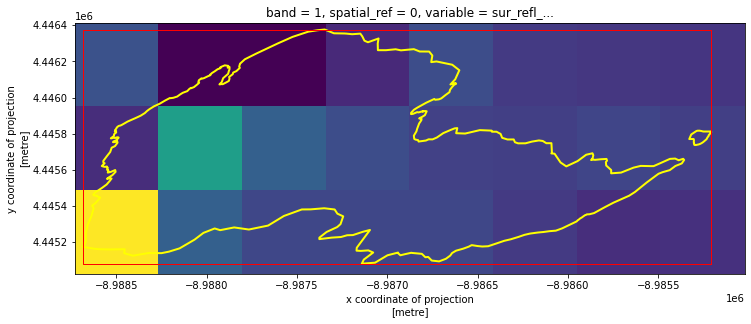

In [74]:
# reprojected box

modis_crop_box_reproj = [box(*fire_boundary_modis.total_bounds)]

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box_reproj,
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_box.plot(ax=ax,
               facecolor="none",
               edgecolor="red",
               linewidth=1)

plt.show()

## Conclusions  -  MODIS  Data  Processing

Much like Landsat, it is cleaner reproject the fire boundary first for MODIS. 

##  Clip Data Using Geometry vs. A Box /  Spatial Extent
Below you can see an example of clipping the data using the geometry 
compared to a box extent.

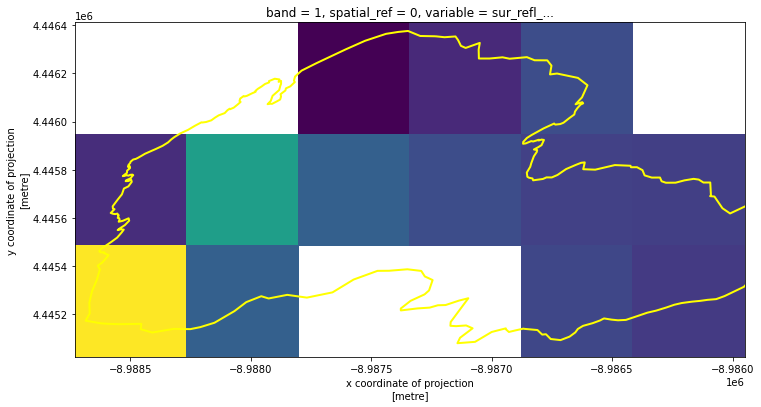

In [75]:
# Crop using the geometry rather than the bounding box
# Comment out crs= you dont need it if the data are already reprojected

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(fire_boundary_modis.geometry.apply(mapping),
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

plt.show()